# MazeDrone with TF Agents

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
#import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2024-06-06 17:41:45.229269: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 17:41:45.233852: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 17:41:45.288800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 17:41:46.618971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [3]:
num_iterations = 20_000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 1_000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Environment

In [4]:
# Some necessary imports 
import sys
sys.path.append('/home/naski/Documents/dev/maze_drone_v02/maze-drone-v02/lib/python3.10/site-packages')
import gym
import gym_maze


In [5]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([1., 0., 1., 0., 5.], dtype=float32)})

#### Aqui vai o código para renderizar um frame do labirinto criado:

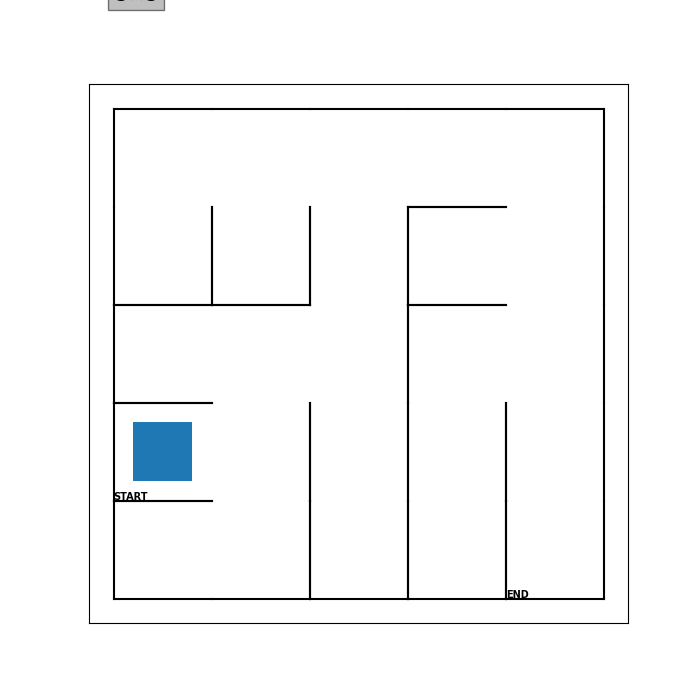

In [6]:
# Rendering enviroment sample 
env.reset()
PIL.Image.fromarray(env.render())

The `time_step_spec()` method returns the specification for the TimeStep tuple. Its observation attribute shows the shape of observations, the data types, and the ranges of allowed values.

The `reward` attribute shows the same details for the reward.

The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(5,), dtype=dtype('float32'), name='observation', minimum=[0. 0. 0. 0. 0.], maximum=[ 1.  1.  1.  1. 20.])


In [8]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [9]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [10]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([1., 0., 1., 0., 5.], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(10., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([0.      , 0.      , 1.      , 0.      , 4.472136], dtype=float32)})


Usually two environments are instantiated: one for training and one for evaluation.

In [11]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [12]:
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent
The DQN agent can be used in any environment which has a **discrete** action space.

At the heart of a DQN Agent is a QNetwork, a neural network model that can learn to predict QValues (expected returns) for all actions, given an observation from the environment.

We will use tf_agents.networks. to create a QNetwork. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [13]:
fc_layer_params = (100, 50) # fc = fully connected
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))
# O uso do inicializador VarianceScaling com mode='fan_in' e 
# distribution='truncated_normal' no seu código é uma estratégia para manter
# a variância dos sinais aproximadamente constante nas camadas densas da rede.
# Crucial para garantir um treinamento eficiente e evitar problemas como o 
# vanishing gradient (gradiente evanescente) e o exploding gradient 
# (gradiente explosivo).

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`.

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Policies

Agents contain two policies:

`agent.policy` — The main policy that is used for evaluation and deployment.

`agent.collect_policy` — A second policy that is used for data collection.



In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. 

In [16]:
# Random policy for baseline
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [17]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load(env_name))

In [18]:
time_step = example_environment.reset()

In [19]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())

### Metrics and Evaluation
The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.




In [20]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [21]:
# Running it on the random policy to get a baseline for the environment
compute_avg_return(eval_env, random_policy, num_eval_episodes)

159.7

### Replay Buffer

In [22]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [23]:
replay_buffer_capacity = replay_buffer_max_length

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch, num_episodes, env_steps]

### Data Collection

In [24]:
#collect_steps_per_iteration = 1

# Data collection:
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [25]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 5), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

### Training the Agent

In [26]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

avg_steps_per_episode_per_eval_interval = []

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 734.8706665039062
step = 400: loss = 3069.16552734375
step = 600: loss = 3195.483642578125
step = 800: loss = 258.748046875
step = 1000: loss = 885.6209716796875
step = 1000: Average Return = 11.0
Avg of Steps/Episode: 50.00
step = 1200: loss = 1163.5675048828125
step = 1400: loss = 128.75296020507812
step = 1600: loss = 1092.51171875
step = 1800: loss = 789.1498413085938
step = 2000: loss = 2660.4423828125
step = 2000: Average Return = 30.0
Avg of Steps/Episode: 22.73
step = 2200: loss = 129.62074279785156
step = 2400: loss = 838.0809936523438
step = 2600: loss = 7341.6103515625
step = 2800: loss = 1733.013671875
step = 3000: loss = 148.0833282470703
step = 3000: Average Return = 17.799999237060547
Avg of Steps/Episode: 20.83
step = 320

## Visualization

In [27]:
import pandas as pd

Text(0.5, 0, 'Iterations')

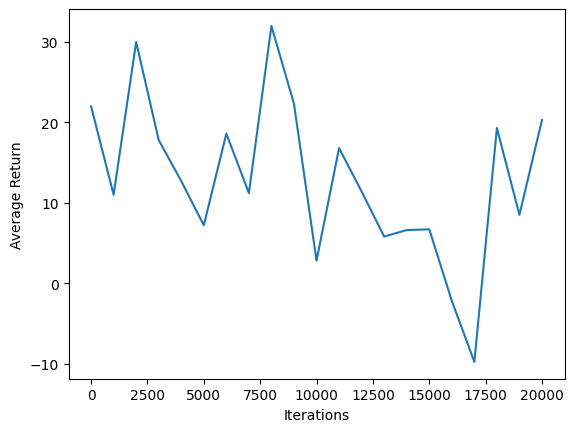

In [28]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return') 
plt.xlabel('Iterations')
#plt.ylim(top=250)

Text(0.5, 0, 'Step')

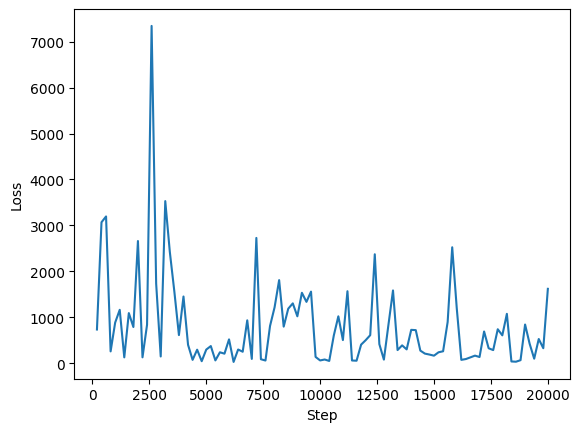

In [29]:
plt.plot(step_log, loss_log)
plt.ylabel('Loss') 
plt.xlabel('Step')

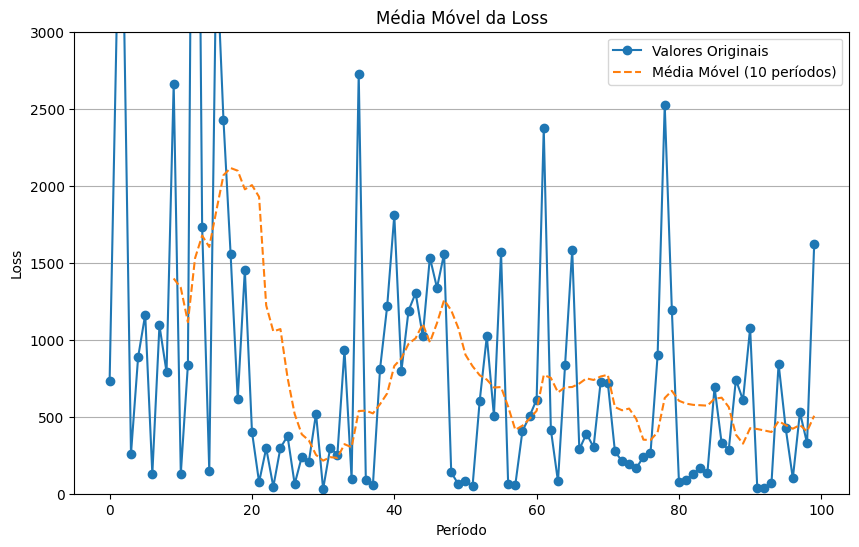

In [30]:
# Loss - média móvel
# Ela serve para suavizar as flutuações de curto prazo em um conjunto de dados, 
# revelando a tendência subjacente e facilitando a identificação de pontos de reversão.
loss_df = pd.DataFrame({'loss': loss_log}) 

periodo_media_movel = 10
loss_df['media_movel'] = loss_df['loss'].rolling(window=periodo_media_movel).mean()

plt.figure(figsize=(10, 6))
plt.plot(loss_df['loss'], label='Valores Originais', marker='o')
plt.plot(loss_df['media_movel'], label=f'Média Móvel ({periodo_media_movel} períodos)', linestyle='dashed')
plt.xlabel('Período')
plt.ylabel('Loss')
plt.title('Média Móvel da Loss')
plt.legend()
plt.grid(axis='y')
plt.ylim(top=3000, bottom=0)
plt.show()

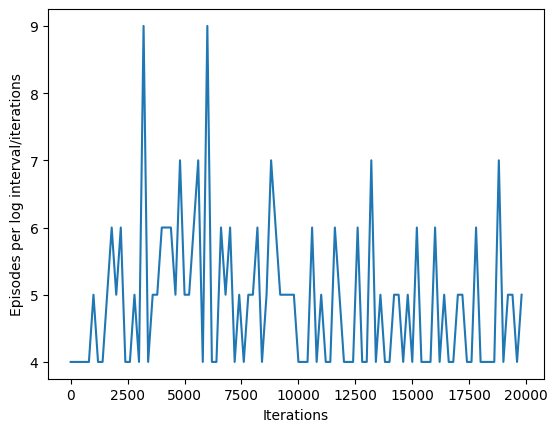

In [31]:
iterations = range(0, num_iterations, log_interval)
plt.plot(iterations, episodes_per_log_interval)
plt.ylabel('Episodes per log interval/iterations') 
plt.xlabel('Iterations')
#plt.ylim(top=50)
plt.show()

Text(0.5, 0, 'Iterations')

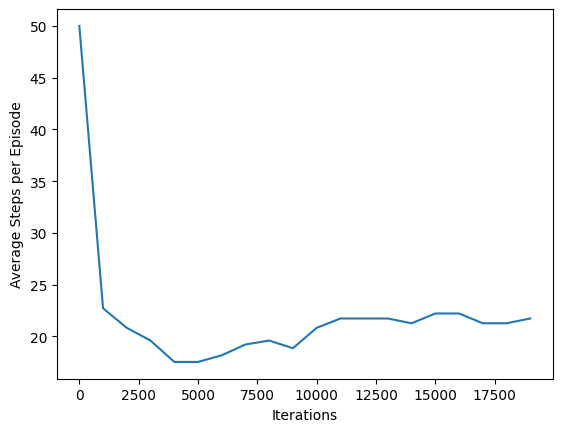

In [32]:
iterations = range(0, num_iterations, eval_interval)
plt.plot(iterations, avg_steps_per_episode_per_eval_interval)
plt.ylabel('Average Steps per Episode') 
plt.xlabel('Iterations')

In [33]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [34]:
def create_policy_eval_video(policy, filename, num_episodes=10, fps=24):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent")

### Keep Training 

In [ ]:
num_iterations = 20_000
for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 20200: loss = 14.524316787719727
step = 20400: loss = 32.11128616333008
step = 20600: loss = 18.896068572998047
step = 20800: loss = 76.78988647460938
step = 21000: loss = 37.724327087402344
step = 21000: Average Return = -27.100000381469727
step = 21200: loss = 26.37540054321289
step = 21400: loss = 65.01314544677734
step = 21600: loss = 6.216178894042969
step = 21800: loss = 18.79369354248047
step = 22000: loss = 7.211029529571533
step = 22000: Average Return = -5.800000190734863
step = 22200: loss = 3.1181607246398926
step = 22400: loss = 6.697871685028076
step = 22600: loss = 6.8166351318359375
step = 22800: loss = 6.887781143188477
step = 23000: loss = 8.509154319763184
step = 23000: Average Return = -14.899999618530273
step = 23200: loss = 2.448822498321533
step = 23400: loss = 2.28326678276062
step = 23600: loss = 4.101899147033691
step = 23800: loss = 11.593500137329102
step = 24000: loss = 0.6835101246833801
step = 24000: Average Return = -15.199999809265137
step = 2420

/home/naski/Documents/dev/maze_drone_v02/maze-drone-v03/lib/python3.10/site-packages/tf_agents/utils/common.py:1539: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []
/home/naski/Documents/dev/maze_drone_v02/maze-drone-v03/lib/python3.10/site-packages/tf_agents/utils/common.py:1539: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []


KeyboardInterrupt: 

Text(0.5, 0, 'Iterations')

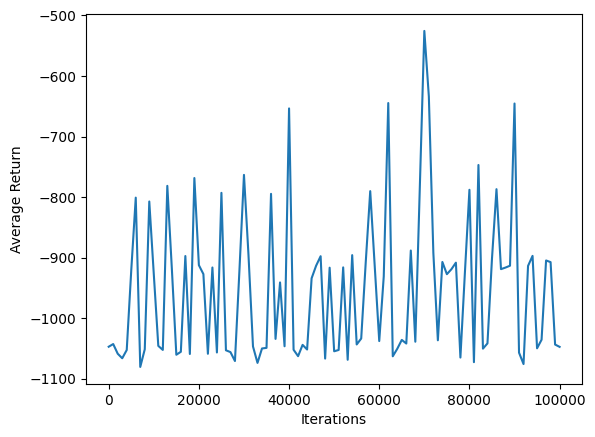

In [ ]:
iterations = range(0, num_iterations + 80_000 + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return') 
plt.xlabel('Iterations')
#plt.ylim(top=250)

ValueError: x and y must have same first dimension, but have shapes (100,) and (80,)

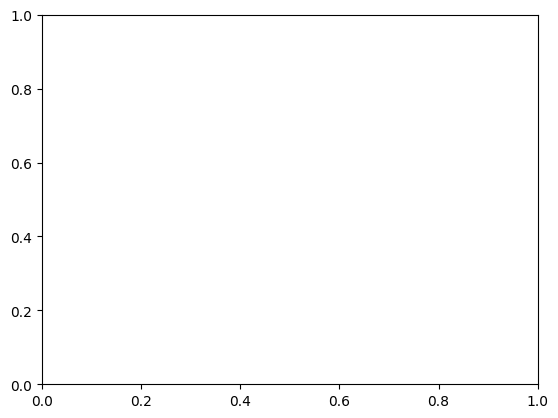

In [ ]:
iterations = range(0, num_iterations + 80_000, eval_interval)
plt.plot(iterations, avg_steps_per_episode_per_eval_interval)
plt.ylabel('Average Steps per Episode') 
plt.xlabel('Iterations')